In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import gensim
import logging
import seaborn as sns
from nltk.corpus import stopwords
import keras
from keras import layers
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline
plt.style.use('ggplot')

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')          
stopWords = list(stopwords.words('english'))    

def tokenize_paragraph(paragraph):
    raw_sentences = tokenizer.tokenize(paragraph)
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_wordlist(raw_sentence.lower()))
    return sentences
            
        
def remove_stopwords(sentences):
    sent_remove_stopwords = []
    for sent in sentences:
        append_sent = []
        for word in sent:
            if word not in stopWords:
                append_sent.append(word)
        sent_remove_stopwords.append(append_sent)
    return sent_remove_stopwords
        
            
def clean_text(paragraph):
    paragraph = paragraph.replace(u'\xa0', u' ')
    sentences = tokenize_paragraph(paragraph)
    sent_remove_stopwords = remove_stopwords(sentences)
    words = []
    for sent in sent_remove_stopwords:
        for word in sent:
            words.append(word)
    return words

def get_paragraph_vectors(tokens):
    num_tokens = len(tokens)
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]
    global model
    model = Doc2Vec(documents, vector_size=300, window=2, min_count=3, workers=10, epochs=25)       
    return [model.docvecs[i] for i in range(num_tokens)]

def get_infered_vectors(tokens):
    return model.infer_vector(tokens)
       
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

def reduce_dimensions(vectors):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    X = [v[0] for v in vectors]
    y = [v[1] for v in vectors]
    return X, y

def get_numpy_array(pandas_series, num_features=300):
    zeroes = np.empty((len(pandas_series),num_features))
    i = 0
    for vectors in pandas_series:
        zeroes[i] = np.array(vectors)
        i+=1
    return zeroes

def get_autoencoder_result(numpy_array):
    encoded_text = encoder.predict(numpy_array)
    return decoder.predict(encoded_text)

def get_vector_difference(initial_vector, decoded_vector):
    return np.absolute(initial_vector.sum() - decoded_vector.sum())

In [3]:
breitbart_csv = 'breitbart_articles_titles.csv'
cnn_csv = 'cnn_articles.csv'
dailywire_csv = 'daily_wire.csv'
reuters_csv = 'reuters_articles.csv'
legitimate_sources = [cnn_csv, reuters_csv]

num_source = len(legitimate_sources)

legit_frames = [None] * num_source

for i in range(num_source):
    legit_frames[i] = pd.read_csv(legitimate_sources[i])

    
legit_frames

[     Unnamed: 0                                            product  \
 0             0  US is at a tipping point of another Covid-19 s...   
 1             1  He adopted a dog that no one else wanted. It e...   
 2             2  Do we really need pants? And other lessons fro...   
 3             3     Here's how to watch the 2021 NBA All-Star game   
 4             4  Wall Street Journal: Third female former staff...   
 ..          ...                                                ...   
 995         995  Attacks against people of Asian descent are on...   
 996         996  This Texas restaurant is offering free meals t...   
 997         997  Strangers took in a delivery driver for 5 days...   
 998         998  A New Jersey plumber drove to Texas with his f...   
 999         999           Trump has CPAC, but Biden has kryptonite   
 
                                                   link  \
 0    https://www.cnn.com/2021/03/07/health/us-coron...   
 1    https://www.cnn.com/20

In [4]:
df = pd.concat(legit_frames)
df = df.drop('Unnamed: 0',axis=1)
df

,product,link,article_content,source
0,US is at a tipping point of another Covid-19 s...,https://www.cnn.com/2021/03/07/health/us-coron...,"But it's not over just yet.Infection numbers, ...",cnn
1,He adopted a dog that no one else wanted. It e...,https://www.cnn.com/2021/03/07/us/rescue-dog-s...,"Want more inspiring, positive news? Sign up fo...",cnn
2,Do we really need pants? And other lessons fro...,https://www.cnn.com/2021/03/07/health/sense-of...,We've missed loved ones and weddings and funer...,cnn
3,Here's how to watch the 2021 NBA All-Star game,https://www.cnn.com/2021/03/07/us/how-to-watch...,The 70th annual NBA All-Star Game will air Sun...,cnn
4,Wall Street Journal: Third female former staff...,https://www.cnn.com/2021/03/07/politics/andrew...,The Democratic governor already stands accused...,cnn
...,...,...,...,...
1165,EY Germany head steps down in wake of Wirecard...,https://www.reuters.com/article/us-wirecard-ac...,"BERLIN (Reuters) - EY Germany said its head, H...",Reuters
1166,India's top brokerage Zerodha faces investor f...,https://www.reuters.com/article/us-india-excha...,MUMBAI (Reuters) - India’s largest brokerage Z...,Reuters
1167,"In Pentagon debut, Biden promises break from T...",https://www.reuters.com/article/us-usa-biden-d...,WASHINGTON (Reuters) - President Joe Biden pro...,Reuters
1168,Biden is 'interested in getting all the facts'...,https://www.reuters.com/article/us-health-coro...,WASHINGTON (Reuters) - President Joe Biden on ...,Reuters


In [5]:
df = df.dropna()
df = df.drop_duplicates()
df

,product,link,article_content,source
0,US is at a tipping point of another Covid-19 s...,https://www.cnn.com/2021/03/07/health/us-coron...,"But it's not over just yet.Infection numbers, ...",cnn
1,He adopted a dog that no one else wanted. It e...,https://www.cnn.com/2021/03/07/us/rescue-dog-s...,"Want more inspiring, positive news? Sign up fo...",cnn
2,Do we really need pants? And other lessons fro...,https://www.cnn.com/2021/03/07/health/sense-of...,We've missed loved ones and weddings and funer...,cnn
3,Here's how to watch the 2021 NBA All-Star game,https://www.cnn.com/2021/03/07/us/how-to-watch...,The 70th annual NBA All-Star Game will air Sun...,cnn
4,Wall Street Journal: Third female former staff...,https://www.cnn.com/2021/03/07/politics/andrew...,The Democratic governor already stands accused...,cnn
...,...,...,...,...
1162,Target to expand Apple offerings in stores and...,https://www.reuters.com/article/us-target-appl...,(Reuters) - Target Corp said on Thursday it wo...,Reuters
1163,"Affirm to launch buy now, pay later debit card...",https://www.reuters.com/article/us-affirm-card...,(Reuters) - San Francisco-based Affirm Holding...,Reuters
1164,Netflix to spend $500 million more to line up ...,https://www.reuters.com/article/us-netflix-sou...,(Reuters) - Netflix Inc said on Thursday it pl...,Reuters
1165,EY Germany head steps down in wake of Wirecard...,https://www.reuters.com/article/us-wirecard-ac...,"BERLIN (Reuters) - EY Germany said its head, H...",Reuters


In [6]:
df['label'] = 0 #Not fake news
df

,product,link,article_content,source,label
0,US is at a tipping point of another Covid-19 s...,https://www.cnn.com/2021/03/07/health/us-coron...,"But it's not over just yet.Infection numbers, ...",cnn,0
1,He adopted a dog that no one else wanted. It e...,https://www.cnn.com/2021/03/07/us/rescue-dog-s...,"Want more inspiring, positive news? Sign up fo...",cnn,0
2,Do we really need pants? And other lessons fro...,https://www.cnn.com/2021/03/07/health/sense-of...,We've missed loved ones and weddings and funer...,cnn,0
3,Here's how to watch the 2021 NBA All-Star game,https://www.cnn.com/2021/03/07/us/how-to-watch...,The 70th annual NBA All-Star Game will air Sun...,cnn,0
4,Wall Street Journal: Third female former staff...,https://www.cnn.com/2021/03/07/politics/andrew...,The Democratic governor already stands accused...,cnn,0
...,...,...,...,...,...
1162,Target to expand Apple offerings in stores and...,https://www.reuters.com/article/us-target-appl...,(Reuters) - Target Corp said on Thursday it wo...,Reuters,0
1163,"Affirm to launch buy now, pay later debit card...",https://www.reuters.com/article/us-affirm-card...,(Reuters) - San Francisco-based Affirm Holding...,Reuters,0
1164,Netflix to spend $500 million more to line up ...,https://www.reuters.com/article/us-netflix-sou...,(Reuters) - Netflix Inc said on Thursday it pl...,Reuters,0
1165,EY Germany head steps down in wake of Wirecard...,https://www.reuters.com/article/us-wirecard-ac...,"BERLIN (Reuters) - EY Germany said its head, H...",Reuters,0


In [7]:
fake_sources = [breitbart_csv, dailywire_csv]

num_source = len(fake_sources)

fake_frames = [None] * num_source

for i in range(num_source):
    fake_frames[i] = pd.read_csv(fake_sources[i])

    
fake_frames

[      Unnamed: 0                                            product  \
 0              0  GOP Lawmakers: Joe Biden’s Border Policies a ‘...   
 1              1  Disney World Tickets Sold Out for Spring Break...   
 2              2  Democrat Abigail Spanberger Flip-Flops in Favo...   
 3              3  Joe Biden Prioritizes Migrant Youth ‘Education...   
 4              4  White House Returns Portraits of Clinton, Bush...   
 ...          ...                                                ...   
 1153        1153  Apple Urges iPhone Users to Update Phones Afte...   
 1154        1154  Bloomberg: Online Investing Forums Are Driving...   
 1155        1155  Poland Urges U.S. to Regulate Big Tech, ‘Every...   
 1156        1156  Bokhari: Biden Will Merge Big Tech Power with ...   
 1157        1157  Govt Minister Tells Breitbart Poland Will Regu...   
 
                                                    link  \
 0     /politics/2021/03/08/gop-lawmakers-joe-bidens-...   
 1     /politi

In [8]:
fake_df = pd.concat(fake_frames)
fake_df

,Unnamed: 0,product,link,article_content,source
0,0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart
1,1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart
2,2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart
3,3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart
4,4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart
...,...,...,...,...,...
975,975,‘End This Uncivil War’: Biden Issues Statement...,https://www.dailywire.com/news/end-this-uncivi...,President Joe Biden issued a statement in resp...,daily wire
976,976,7 Republicans Who Found Trump 'Guilty' Of Inci...,https://www.dailywire.com/news/7-republicans-w...,“I voted to convict President Trump because he...,daily wire
977,977,TRUMP'S BACK: Former President Celebrates Acqu...,https://www.dailywire.com/news/trumps-back-for...,"""I look forward to continuing our incredible j...",daily wire
978,978,New York DA Now Looking Into Loans Given For T...,https://www.dailywire.com/news/new-york-da-now...,As part of its continued search to find someth...,daily wire


In [9]:
fake_df = fake_df.drop('Unnamed: 0',axis=1)
fake_df = fake_df.dropna()
fake_df = fake_df.drop_duplicates()
fake_df

,product,link,article_content,source
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart
...,...,...,...,...
975,‘End This Uncivil War’: Biden Issues Statement...,https://www.dailywire.com/news/end-this-uncivi...,President Joe Biden issued a statement in resp...,daily wire
976,7 Republicans Who Found Trump 'Guilty' Of Inci...,https://www.dailywire.com/news/7-republicans-w...,“I voted to convict President Trump because he...,daily wire
977,TRUMP'S BACK: Former President Celebrates Acqu...,https://www.dailywire.com/news/trumps-back-for...,"""I look forward to continuing our incredible j...",daily wire
978,New York DA Now Looking Into Loans Given For T...,https://www.dailywire.com/news/new-york-da-now...,As part of its continued search to find someth...,daily wire


In [10]:
fake_df['label'] = 1 #presence of fake news
fake_df

,product,link,article_content,source,label
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart,1
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart,1
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart,1
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart,1
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart,1
...,...,...,...,...,...
975,‘End This Uncivil War’: Biden Issues Statement...,https://www.dailywire.com/news/end-this-uncivi...,President Joe Biden issued a statement in resp...,daily wire,1
976,7 Republicans Who Found Trump 'Guilty' Of Inci...,https://www.dailywire.com/news/7-republicans-w...,“I voted to convict President Trump because he...,daily wire,1
977,TRUMP'S BACK: Former President Celebrates Acqu...,https://www.dailywire.com/news/trumps-back-for...,"""I look forward to continuing our incredible j...",daily wire,1
978,New York DA Now Looking Into Loans Given For T...,https://www.dailywire.com/news/new-york-da-now...,As part of its continued search to find someth...,daily wire,1


In [11]:
df[df.source == 'cnn'].tail().index

Int64Index([995, 996, 997, 998, 999], dtype='int64')

In [12]:
df[df.source=='Reuters'].tail().index

Int64Index([1162, 1163, 1164, 1165, 1166], dtype='int64')

In [13]:
fake_df[fake_df.source == 'breitbart'].tail().index 

Int64Index([1153, 1154, 1155, 1156, 1157], dtype='int64')

In [14]:
fake_df[fake_df.source == 'daily wire'].tail().index

Int64Index([975, 976, 977, 978, 979], dtype='int64')

In [15]:
df_drop_indicies = []
df_drop_indicies.extend(df.head(50).index)
df_drop_indicies.extend(df[df.source=='Reuters'].tail(50).index)
df_drop_indicies

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 1101,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1132,
 1133,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1144,
 1145,
 1146,
 1147,
 1148,
 1149,
 1150,
 1151,
 1152,
 1153,
 1157,
 1158,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166]

In [16]:
fake_df_drop_indicies = []
fake_df_drop_indicies.extend(fake_df[fake_df.source == 'breitbart'].tail().index)
fake_df_drop_indicies.extend(fake_df[fake_df.source == 'daily wire'].tail().index)
fake_df_drop_indicies

[1153, 1154, 1155, 1156, 1157, 975, 976, 977, 978, 979]

In [17]:
#split frames into 2: majority legitimate frames and majority fake frames
fake_frames_to_transfer = fake_df.iloc[fake_df_drop_indicies]
frames_to_transfer = df.iloc[df_drop_indicies]
df = df.drop(df_drop_indicies)
df

,product,link,article_content,source,label
53,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0
54,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0
55,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0
56,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0
58,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0
...,...,...,...,...,...
1096,Eight U.S. auto state governors urge Biden to ...,https://www.reuters.com/article/us-usa-supply-...,WASHINGTON (Reuters) - A bipartisan group of e...,Reuters,0
1097,Short-sellers take aim at Chinese blockchain f...,https://www.reuters.com/article/us-sos-hindenb...,(Reuters) - Short-sellers Hindenburg Research ...,Reuters,0
1098,UK seeks G7 consensus on digital competition a...,https://www.reuters.com/article/us-australia-m...,LONDON (Reuters) - Britain is seeking to build...,Reuters,0
1099,Dutch competition regulators nearing draft dec...,https://www.reuters.com/article/us-netherlands...,(Reuters) - Dutch competition authorities are ...,Reuters,0


In [18]:
frames_to_transfer

,product,link,article_content,source,label
0,US is at a tipping point of another Covid-19 s...,https://www.cnn.com/2021/03/07/health/us-coron...,"But it's not over just yet.Infection numbers, ...",cnn,0
1,He adopted a dog that no one else wanted. It e...,https://www.cnn.com/2021/03/07/us/rescue-dog-s...,"Want more inspiring, positive news? Sign up fo...",cnn,0
2,Do we really need pants? And other lessons fro...,https://www.cnn.com/2021/03/07/health/sense-of...,We've missed loved ones and weddings and funer...,cnn,0
3,Here's how to watch the 2021 NBA All-Star game,https://www.cnn.com/2021/03/07/us/how-to-watch...,The 70th annual NBA All-Star Game will air Sun...,cnn,0
4,Wall Street Journal: Third female former staff...,https://www.cnn.com/2021/03/07/politics/andrew...,The Democratic governor already stands accused...,cnn,0
...,...,...,...,...,...
277,Activists paint barriers with names of female ...,https://www.reuters.com/article/us-womens-day-...,MEXICO CITY (Reuters) - The names of women vic...,Reuters,0
278,Ruling RHDP party wins majority in Ivory Coast...,https://www.reuters.com/article/us-ivorycoast-...,DAKAR (Reuters) - Ivory Coast’s ruling party w...,Reuters,0
279,Dynamite explosions at army base in Equatorial...,https://www.reuters.com/article/us-equatorial-...,MALABO (Reuters) - A series of large explosion...,Reuters,0
280,Libyan MPs arrive at Sirte to debate unity gov...,https://www.reuters.com/article/us-libya-secur...,"SIRTE, Libya (Reuters) - Scores of Libyan parl...",Reuters,0


In [19]:
fake_df = pd.concat([fake_df,frames_to_transfer])
fake_df

,product,link,article_content,source,label
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart,1
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart,1
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart,1
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart,1
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart,1
...,...,...,...,...,...
277,Activists paint barriers with names of female ...,https://www.reuters.com/article/us-womens-day-...,MEXICO CITY (Reuters) - The names of women vic...,Reuters,0
278,Ruling RHDP party wins majority in Ivory Coast...,https://www.reuters.com/article/us-ivorycoast-...,DAKAR (Reuters) - Ivory Coast’s ruling party w...,Reuters,0
279,Dynamite explosions at army base in Equatorial...,https://www.reuters.com/article/us-equatorial-...,MALABO (Reuters) - A series of large explosion...,Reuters,0
280,Libyan MPs arrive at Sirte to debate unity gov...,https://www.reuters.com/article/us-libya-secur...,"SIRTE, Libya (Reuters) - Scores of Libyan parl...",Reuters,0


In [20]:
df.source.value_counts()

cnn        835
Reuters    801
Name: source, dtype: int64

In [21]:
fake_df.source.value_counts()

breitbart     1051
daily wire     980
Reuters         50
cnn             50
Name: source, dtype: int64

In [22]:
df.tail(10).index

Int64Index([1088, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100], dtype='int64')

In [23]:
df.columns

Index(['product', 'link', 'article_content', 'source', 'label'], dtype='object')

In [24]:
test_text = df.iloc[0,2]

In [25]:
df['tokens'] = df.article_content.apply(clean_text)
df

<ipython-input-25-44b3aba4c301>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df.article_content.apply(clean_text)


,product,link,article_content,source,label,tokens
53,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0,"[main, caretaker, immunocompromised, mother, s..."
54,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0,"[security, guard, tailed, walk, home, tonight,..."
55,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0,"[route, usually, almost, miles, modified, avoi..."
56,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0,"[us, customs, border, protection, attributed, ..."
58,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0,"[fairground, park, pool, st, louis, largest, p..."
...,...,...,...,...,...,...
1096,Eight U.S. auto state governors urge Biden to ...,https://www.reuters.com/article/us-usa-supply-...,WASHINGTON (Reuters) - A bipartisan group of e...,Reuters,0,"[washington, reuters, bipartisan, group, eight..."
1097,Short-sellers take aim at Chinese blockchain f...,https://www.reuters.com/article/us-sos-hindenb...,(Reuters) - Short-sellers Hindenburg Research ...,Reuters,0,"[reuters, short, sellers, hindenburg, research..."
1098,UK seeks G7 consensus on digital competition a...,https://www.reuters.com/article/us-australia-m...,LONDON (Reuters) - Britain is seeking to build...,Reuters,0,"[london, reuters, britain, seeking, build, con..."
1099,Dutch competition regulators nearing draft dec...,https://www.reuters.com/article/us-netherlands...,(Reuters) - Dutch competition authorities are ...,Reuters,0,"[reuters, dutch, competition, authorities, nea..."


In [26]:
tokens = list(df.tokens)

In [27]:
vectors = get_paragraph_vectors(tokens)

2021-03-19 00:15:38,730 : INFO : collecting all words and their counts
2021-03-19 00:15:38,731 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-03-19 00:15:38,808 : INFO : collected 31389 word types and 1636 unique tags from a corpus of 1636 examples and 539329 words
2021-03-19 00:15:38,809 : INFO : Loading a fresh vocabulary
2021-03-19 00:15:38,835 : INFO : effective_min_count=3 retains 15381 unique words (49% of original 31389, drops 16008)
2021-03-19 00:15:38,835 : INFO : effective_min_count=3 leaves 518859 word corpus (96% of original 539329, drops 20470)
2021-03-19 00:15:38,867 : INFO : deleting the raw counts dictionary of 31389 items
2021-03-19 00:15:38,868 : INFO : sample=0.001 downsamples 15 most-common words
2021-03-19 00:15:38,869 : INFO : downsampling leaves estimated 509018 word corpus (98.1% of prior 518859)
2021-03-19 00:15:38,894 : INFO : estimated required memory for 15381 words and 300 dimensions: 46568100 bytes
2021-03-19 00:15:38,

2021-03-19 00:15:43,918 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-19 00:15:43,919 : INFO : EPOCH - 7 : training on 539329 raw words (510576 effective words) took 0.4s, 1441754 effective words/s
2021-03-19 00:15:44,232 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-19 00:15:44,240 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-19 00:15:44,248 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-19 00:15:44,252 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-19 00:15:44,259 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-19 00:15:44,267 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-19 00:15:44,271 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-19 00:15:44,278 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-19 00:15:44,280 : INFO : worker threa

2021-03-19 00:15:46,794 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-19 00:15:46,795 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-19 00:15:46,795 : INFO : EPOCH - 15 : training on 539329 raw words (510763 effective words) took 0.3s, 1468384 effective words/s
2021-03-19 00:15:47,091 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-19 00:15:47,102 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-19 00:15:47,106 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-19 00:15:47,111 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-19 00:15:47,119 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-19 00:15:47,127 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-19 00:15:47,133 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-19 00:15:47,136 : INFO : worker thre

2021-03-19 00:15:49,568 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-19 00:15:49,573 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-19 00:15:49,574 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-19 00:15:49,574 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-19 00:15:49,575 : INFO : EPOCH - 23 : training on 539329 raw words (510557 effective words) took 0.4s, 1448265 effective words/s
2021-03-19 00:15:49,866 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-19 00:15:49,883 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-19 00:15:49,887 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-19 00:15:49,893 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-19 00:15:49,898 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-19 00:15:49,914 : INFO : worker thre

In [28]:
df['vectors'] = vectors
df

<ipython-input-28-9a25740daa0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vectors'] = vectors


,product,link,article_content,source,label,tokens,vectors
53,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0,"[main, caretaker, immunocompromised, mother, s...","[-0.6517257, -0.58543515, 0.5543676, 0.4576794..."
54,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0,"[security, guard, tailed, walk, home, tonight,...","[-0.54537237, -0.036030173, 0.5389945, 0.30385..."
55,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0,"[route, usually, almost, miles, modified, avoi...","[-0.095070474, -0.22879435, -0.19022776, 0.364..."
56,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0,"[us, customs, border, protection, attributed, ...","[0.40281138, 0.25570744, 0.2818255, 0.5900684,..."
58,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0,"[fairground, park, pool, st, louis, largest, p...","[-0.560412, 0.64223176, -0.060790766, 1.203968..."
...,...,...,...,...,...,...,...
1096,Eight U.S. auto state governors urge Biden to ...,https://www.reuters.com/article/us-usa-supply-...,WASHINGTON (Reuters) - A bipartisan group of e...,Reuters,0,"[washington, reuters, bipartisan, group, eight...","[0.24208039, -0.39323992, 0.047398526, -0.1769..."
1097,Short-sellers take aim at Chinese blockchain f...,https://www.reuters.com/article/us-sos-hindenb...,(Reuters) - Short-sellers Hindenburg Research ...,Reuters,0,"[reuters, short, sellers, hindenburg, research...","[0.010988747, -0.5391541, 0.6470802, 0.0194398..."
1098,UK seeks G7 consensus on digital competition a...,https://www.reuters.com/article/us-australia-m...,LONDON (Reuters) - Britain is seeking to build...,Reuters,0,"[london, reuters, britain, seeking, build, con...","[-0.3698708, -0.09705572, 0.49334937, -0.01731..."
1099,Dutch competition regulators nearing draft dec...,https://www.reuters.com/article/us-netherlands...,(Reuters) - Dutch competition authorities are ...,Reuters,0,"[reuters, dutch, competition, authorities, nea...","[-0.552599, -0.28498882, 0.57732874, 0.0354997..."


In [29]:
X, y = reduce_dimensions(list(df.vectors))

In [30]:
df['tsne_X'] = X
df['tsne_y'] = y

<ipython-input-30-887e8641da49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne_X'] = X
<ipython-input-30-887e8641da49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne_y'] = y


In [31]:
df.head()

,product,link,article_content,source,label,tokens,vectors,tsne_X,tsne_y
53,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0,"[main, caretaker, immunocompromised, mother, s...","[-0.6517257, -0.58543515, 0.5543676, 0.4576794...",22.363464,15.868487
54,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0,"[security, guard, tailed, walk, home, tonight,...","[-0.54537237, -0.036030173, 0.5389945, 0.30385...",-17.793360,15.806241
55,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0,"[route, usually, almost, miles, modified, avoi...","[-0.095070474, -0.22879435, -0.19022776, 0.364...",1.831776,23.378225
56,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0,"[us, customs, border, protection, attributed, ...","[0.40281138, 0.25570744, 0.2818255, 0.5900684,...",4.375418,12.266811
58,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0,"[fairground, park, pool, st, louis, largest, p...","[-0.560412, 0.64223176, -0.060790766, 1.203968...",-12.405573,20.319353


Text(0.5, 1.0, '2D Representation of Document Vectors')

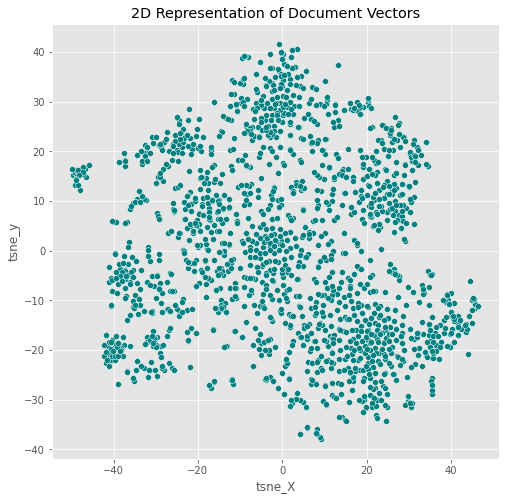

In [32]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='tsne_X',y='tsne_y',color='teal')
plt.title('2D Representation of Document Vectors')

In [33]:
df.tsne_X

53      22.363464
54     -17.793360
55       1.831776
56       4.375418
58     -12.405573
          ...    
1096     5.788515
1097    26.110470
1098    -4.067685
1099     0.900595
1100    15.115113
Name: tsne_X, Length: 1636, dtype: float64

In [34]:
km = KMeans()
model_inputs = []
for i in range(len(df.tsne_X)):
    model_inputs.append([df.tsne_X.iloc[i],df.tsne_y.iloc[i]])
labels = km.fit_predict(model_inputs)
labels

array([3, 4, 1, ..., 2, 0, 0])

In [35]:
df['KMeans_labels'] = labels

<ipython-input-35-2d96e503fac9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KMeans_labels'] = labels


In [36]:
df

,product,link,article_content,source,label,tokens,vectors,tsne_X,tsne_y,KMeans_labels
53,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0,"[main, caretaker, immunocompromised, mother, s...","[-0.6517257, -0.58543515, 0.5543676, 0.4576794...",22.363464,15.868487,3
54,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0,"[security, guard, tailed, walk, home, tonight,...","[-0.54537237, -0.036030173, 0.5389945, 0.30385...",-17.793360,15.806241,4
55,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0,"[route, usually, almost, miles, modified, avoi...","[-0.095070474, -0.22879435, -0.19022776, 0.364...",1.831776,23.378225,1
56,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0,"[us, customs, border, protection, attributed, ...","[0.40281138, 0.25570744, 0.2818255, 0.5900684,...",4.375418,12.266811,6
58,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0,"[fairground, park, pool, st, louis, largest, p...","[-0.560412, 0.64223176, -0.060790766, 1.203968...",-12.405573,20.319353,1
...,...,...,...,...,...,...,...,...,...,...
1096,Eight U.S. auto state governors urge Biden to ...,https://www.reuters.com/article/us-usa-supply-...,WASHINGTON (Reuters) - A bipartisan group of e...,Reuters,0,"[washington, reuters, bipartisan, group, eight...","[0.24208039, -0.39323992, 0.047398526, -0.1769...",5.788515,-15.194035,0
1097,Short-sellers take aim at Chinese blockchain f...,https://www.reuters.com/article/us-sos-hindenb...,(Reuters) - Short-sellers Hindenburg Research ...,Reuters,0,"[reuters, short, sellers, hindenburg, research...","[0.010988747, -0.5391541, 0.6470802, 0.0194398...",26.110470,-16.804249,5
1098,UK seeks G7 consensus on digital competition a...,https://www.reuters.com/article/us-australia-m...,LONDON (Reuters) - Britain is seeking to build...,Reuters,0,"[london, reuters, britain, seeking, build, con...","[-0.3698708, -0.09705572, 0.49334937, -0.01731...",-4.067685,-19.890642,2
1099,Dutch competition regulators nearing draft dec...,https://www.reuters.com/article/us-netherlands...,(Reuters) - Dutch competition authorities are ...,Reuters,0,"[reuters, dutch, competition, authorities, nea...","[-0.552599, -0.28498882, 0.57732874, 0.0354997...",0.900595,-21.893311,0


Text(0.5, 1.0, 'Clustered DocVecs')

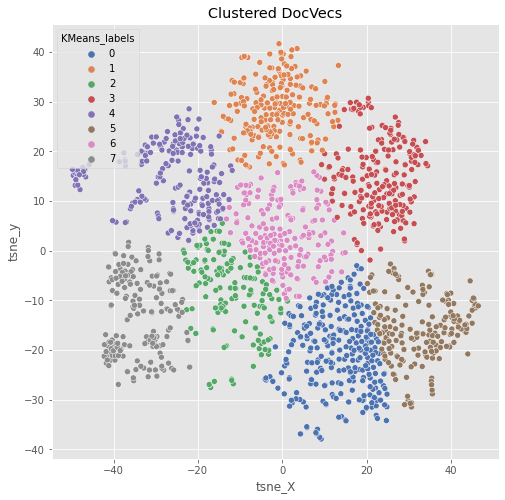

In [37]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df,x='tsne_X',y='tsne_y',hue='KMeans_labels',palette='deep')
plt.title('Clustered DocVecs')

In [38]:
for title in df[df.KMeans_labels==0]['product']:
    print(title)

John McAfee facing charges for alleged cryptocurrency 'pump and dump' scheme on Twitter
Twitter is testing an 'undo' option after sending tweets
People are turning to Nextdoor for tips on getting a vaccine. Why that may be a problem
Your self-driving car still isn't ready. Smarter roads might change that
What it says about us when we want a cook's recipe but not their humanity
Stores are closing. This discount chain plans to move in
Grocery stores' pandemic boom is over
Ford's Mustang Mach-E is eating into Tesla's US sales
T-Mobile is a consumer favorite. Now it's trying to break into the business world
Square to acquire majority stake in music service Tidal for $297 million
Amazon's first physical store outside the US doesn't have a checkout line
UK launches antitrust probe into Apple
This 'snake robot' can fix pipelines on the ocean floor
Disney is closing 60 stores in the US and Canada
Dollar Tree announces new stores as demand for discount retailers skyrockets
Sinclair to lay off h

In [39]:
fake_df.label = fake_df.label.replace(to_replace=0,value=-1)

In [40]:
fake_df['tokens'] = fake_df['article_content'].apply(clean_text)
fake_df

,product,link,article_content,source,label,tokens
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart,1,"[group, house, republicans, sent, letter, depa..."
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart,1,"[happiest, place, earth, bursting, seams, spri..."
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart,1,"[rep, abigail, spanberger, va, voted, tuesday,..."
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart,1,"[president, joe, biden, administration, focuse..."
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart,1,"[white, house, announced, return, portraits, f..."
...,...,...,...,...,...,...
277,Activists paint barriers with names of female ...,https://www.reuters.com/article/us-womens-day-...,MEXICO CITY (Reuters) - The names of women vic...,Reuters,-1,"[mexico, city, reuters, names, women, victimiz..."
278,Ruling RHDP party wins majority in Ivory Coast...,https://www.reuters.com/article/us-ivorycoast-...,DAKAR (Reuters) - Ivory Coast’s ruling party w...,Reuters,-1,"[dakar, reuters, ivory, coast, ruling, party, ..."
279,Dynamite explosions at army base in Equatorial...,https://www.reuters.com/article/us-equatorial-...,MALABO (Reuters) - A series of large explosion...,Reuters,-1,"[malabo, reuters, series, large, explosions, m..."
280,Libyan MPs arrive at Sirte to debate unity gov...,https://www.reuters.com/article/us-libya-secur...,"SIRTE, Libya (Reuters) - Scores of Libyan parl...",Reuters,-1,"[sirte, libya, reuters, scores, libyan, parlia..."


In [41]:
fake_df['vectors'] = fake_df['tokens'].apply(get_infered_vectors)
fake_df

,product,link,article_content,source,label,tokens,vectors
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart,1,"[group, house, republicans, sent, letter, depa...","[-0.628464, -0.28403303, -0.1034104, -0.141886..."
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart,1,"[happiest, place, earth, bursting, seams, spri...","[-0.18924332, -0.2624545, 0.59482265, -0.07639..."
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart,1,"[rep, abigail, spanberger, va, voted, tuesday,...","[-0.5094472, 0.58957505, 0.31214395, -0.408755..."
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart,1,"[president, joe, biden, administration, focuse...","[-0.4736634, 0.4127279, -0.6665505, -0.0222593..."
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart,1,"[white, house, announced, return, portraits, f...","[-0.15285647, 0.07105932, 0.117245905, 0.36412..."
...,...,...,...,...,...,...,...
277,Activists paint barriers with names of female ...,https://www.reuters.com/article/us-womens-day-...,MEXICO CITY (Reuters) - The names of women vic...,Reuters,-1,"[mexico, city, reuters, names, women, victimiz...","[-1.1972796, -0.03920891, 1.1315296, 0.0023020..."
278,Ruling RHDP party wins majority in Ivory Coast...,https://www.reuters.com/article/us-ivorycoast-...,DAKAR (Reuters) - Ivory Coast’s ruling party w...,Reuters,-1,"[dakar, reuters, ivory, coast, ruling, party, ...","[-0.6283255, -0.46752945, 0.3191623, 0.7113648..."
279,Dynamite explosions at army base in Equatorial...,https://www.reuters.com/article/us-equatorial-...,MALABO (Reuters) - A series of large explosion...,Reuters,-1,"[malabo, reuters, series, large, explosions, m...","[-0.18683566, -0.1433568, 0.9069601, 0.5325149..."
280,Libyan MPs arrive at Sirte to debate unity gov...,https://www.reuters.com/article/us-libya-secur...,"SIRTE, Libya (Reuters) - Scores of Libyan parl...",Reuters,-1,"[sirte, libya, reuters, scores, libyan, parlia...","[-0.22225226, -0.22291505, 0.32047728, 0.49419..."


In [42]:
X, y = reduce_dimensions(list(fake_df.vectors))
fake_df['tsne_X'] = X
fake_df['tsne_y'] = y

In [43]:
fake_df

,product,link,article_content,source,label,tokens,vectors,tsne_X,tsne_y
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart,1,"[group, house, republicans, sent, letter, depa...","[-0.628464, -0.28403303, -0.1034104, -0.141886...",-2.873448,-20.075176
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart,1,"[happiest, place, earth, bursting, seams, spri...","[-0.18924332, -0.2624545, 0.59482265, -0.07639...",-1.327473,-2.730221
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart,1,"[rep, abigail, spanberger, va, voted, tuesday,...","[-0.5094472, 0.58957505, 0.31214395, -0.408755...",-27.933523,-11.935261
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart,1,"[president, joe, biden, administration, focuse...","[-0.4736634, 0.4127279, -0.6665505, -0.0222593...",-3.332874,-17.809422
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart,1,"[white, house, announced, return, portraits, f...","[-0.15285647, 0.07105932, 0.117245905, 0.36412...",5.406460,3.886958
...,...,...,...,...,...,...,...,...,...
277,Activists paint barriers with names of female ...,https://www.reuters.com/article/us-womens-day-...,MEXICO CITY (Reuters) - The names of women vic...,Reuters,-1,"[mexico, city, reuters, names, women, victimiz...","[-1.1972796, -0.03920891, 1.1315296, 0.0023020...",14.529819,-11.177903
278,Ruling RHDP party wins majority in Ivory Coast...,https://www.reuters.com/article/us-ivorycoast-...,DAKAR (Reuters) - Ivory Coast’s ruling party w...,Reuters,-1,"[dakar, reuters, ivory, coast, ruling, party, ...","[-0.6283255, -0.46752945, 0.3191623, 0.7113648...",10.475356,-15.216311
279,Dynamite explosions at army base in Equatorial...,https://www.reuters.com/article/us-equatorial-...,MALABO (Reuters) - A series of large explosion...,Reuters,-1,"[malabo, reuters, series, large, explosions, m...","[-0.18683566, -0.1433568, 0.9069601, 0.5325149...",15.867410,-13.774384
280,Libyan MPs arrive at Sirte to debate unity gov...,https://www.reuters.com/article/us-libya-secur...,"SIRTE, Libya (Reuters) - Scores of Libyan parl...",Reuters,-1,"[sirte, libya, reuters, scores, libyan, parlia...","[-0.22225226, -0.22291505, 0.32047728, 0.49419...",13.321461,-24.788374


In [44]:
df_index = list(range(0,1636))
fake_df_index = list(range(1636,(1636+2131)))
len(df_index)

1636

In [45]:
df.index


Int64Index([  53,   54,   55,   56,   58,   59,   60,   61,   62,   63,
            ...
            1088, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100],
           dtype='int64', length=1636)

In [46]:
fake_df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            272, 273, 274, 275, 276, 277, 278, 279, 280, 281],
           dtype='int64', length=2131)

In [47]:
df = df.set_axis(df_index, axis='index')

In [48]:
fake_df = fake_df.set_axis(fake_df_index,axis='index')

In [49]:
df

,product,link,article_content,source,label,tokens,vectors,tsne_X,tsne_y,KMeans_labels
0,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0,"[main, caretaker, immunocompromised, mother, s...","[-0.6517257, -0.58543515, 0.5543676, 0.4576794...",22.363464,15.868487,3
1,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0,"[security, guard, tailed, walk, home, tonight,...","[-0.54537237, -0.036030173, 0.5389945, 0.30385...",-17.793360,15.806241,4
2,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0,"[route, usually, almost, miles, modified, avoi...","[-0.095070474, -0.22879435, -0.19022776, 0.364...",1.831776,23.378225,1
3,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0,"[us, customs, border, protection, attributed, ...","[0.40281138, 0.25570744, 0.2818255, 0.5900684,...",4.375418,12.266811,6
4,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0,"[fairground, park, pool, st, louis, largest, p...","[-0.560412, 0.64223176, -0.060790766, 1.203968...",-12.405573,20.319353,1
...,...,...,...,...,...,...,...,...,...,...
1631,Eight U.S. auto state governors urge Biden to ...,https://www.reuters.com/article/us-usa-supply-...,WASHINGTON (Reuters) - A bipartisan group of e...,Reuters,0,"[washington, reuters, bipartisan, group, eight...","[0.24208039, -0.39323992, 0.047398526, -0.1769...",5.788515,-15.194035,0
1632,Short-sellers take aim at Chinese blockchain f...,https://www.reuters.com/article/us-sos-hindenb...,(Reuters) - Short-sellers Hindenburg Research ...,Reuters,0,"[reuters, short, sellers, hindenburg, research...","[0.010988747, -0.5391541, 0.6470802, 0.0194398...",26.110470,-16.804249,5
1633,UK seeks G7 consensus on digital competition a...,https://www.reuters.com/article/us-australia-m...,LONDON (Reuters) - Britain is seeking to build...,Reuters,0,"[london, reuters, britain, seeking, build, con...","[-0.3698708, -0.09705572, 0.49334937, -0.01731...",-4.067685,-19.890642,2
1634,Dutch competition regulators nearing draft dec...,https://www.reuters.com/article/us-netherlands...,(Reuters) - Dutch competition authorities are ...,Reuters,0,"[reuters, dutch, competition, authorities, nea...","[-0.552599, -0.28498882, 0.57732874, 0.0354997...",0.900595,-21.893311,0


In [50]:
combined_df = pd.concat([df,fake_df])
combined_df

,product,link,article_content,source,label,tokens,vectors,tsne_X,tsne_y,KMeans_labels
0,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0,"[main, caretaker, immunocompromised, mother, s...","[-0.6517257, -0.58543515, 0.5543676, 0.4576794...",22.363464,15.868487,3.0
1,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0,"[security, guard, tailed, walk, home, tonight,...","[-0.54537237, -0.036030173, 0.5389945, 0.30385...",-17.793360,15.806241,4.0
2,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0,"[route, usually, almost, miles, modified, avoi...","[-0.095070474, -0.22879435, -0.19022776, 0.364...",1.831776,23.378225,1.0
3,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0,"[us, customs, border, protection, attributed, ...","[0.40281138, 0.25570744, 0.2818255, 0.5900684,...",4.375418,12.266811,6.0
4,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0,"[fairground, park, pool, st, louis, largest, p...","[-0.560412, 0.64223176, -0.060790766, 1.203968...",-12.405573,20.319353,1.0
...,...,...,...,...,...,...,...,...,...,...
3762,Activists paint barriers with names of female ...,https://www.reuters.com/article/us-womens-day-...,MEXICO CITY (Reuters) - The names of women vic...,Reuters,-1,"[mexico, city, reuters, names, women, victimiz...","[-1.1972796, -0.03920891, 1.1315296, 0.0023020...",14.529819,-11.177903,NaN
3763,Ruling RHDP party wins majority in Ivory Coast...,https://www.reuters.com/article/us-ivorycoast-...,DAKAR (Reuters) - Ivory Coast’s ruling party w...,Reuters,-1,"[dakar, reuters, ivory, coast, ruling, party, ...","[-0.6283255, -0.46752945, 0.3191623, 0.7113648...",10.475356,-15.216311,NaN
3764,Dynamite explosions at army base in Equatorial...,https://www.reuters.com/article/us-equatorial-...,MALABO (Reuters) - A series of large explosion...,Reuters,-1,"[malabo, reuters, series, large, explosions, m...","[-0.18683566, -0.1433568, 0.9069601, 0.5325149...",15.867410,-13.774384,NaN
3765,Libyan MPs arrive at Sirte to debate unity gov...,https://www.reuters.com/article/us-libya-secur...,"SIRTE, Libya (Reuters) - Scores of Libyan parl...",Reuters,-1,"[sirte, libya, reuters, scores, libyan, parlia...","[-0.22225226, -0.22291505, 0.32047728, 0.49419...",13.321461,-24.788374,NaN


In [51]:
df.drop(['article_content','tokens','vectors'],axis=1).to_csv('news_word_vectors.csv')

In [52]:
combined_df.drop(['article_content','tokens','vectors'],axis=1).to_csv('combined_vectors.csv')

<AxesSubplot:xlabel='tsne_X', ylabel='tsne_y'>

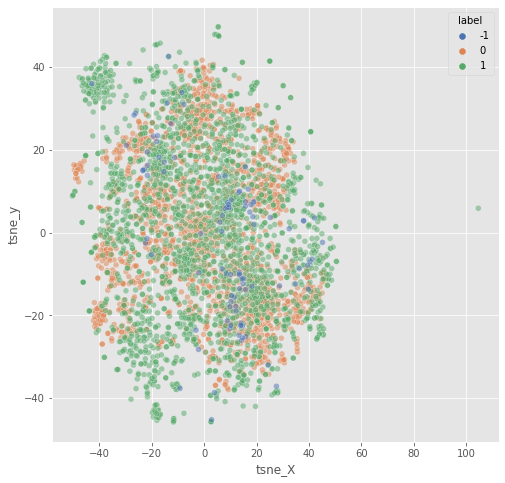

In [53]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=combined_df,x='tsne_X',y='tsne_y',hue='label',palette='deep',alpha=0.5)

Text(0.5, 1.0, '2D Representation of Document Vectors')

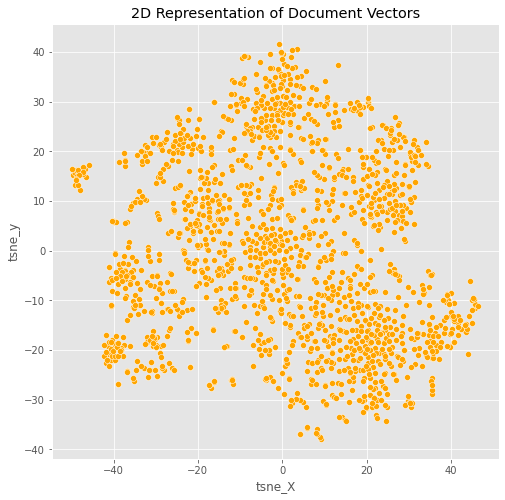

In [54]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='tsne_X',y='tsne_y',color='orange')
plt.title('2D Representation of Document Vectors')

In [55]:
for i in combined_df[combined_df.tsne_X>100]['link']:
    print(i)

https://www.dailywire.com/news/prageru-a-fathers-questions-for-black-lives-matter


In [56]:
encoding_dim = 2

input_text = keras.Input(shape=(300,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_text)
decoded = layers.Dense(300, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_text, decoded)

encoder = keras.Model(input_text, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [57]:
train_set, test_set = train_test_split(df.vectors, test_size=0.2, random_state=42)

In [58]:
vectors = pd.to_numeric(df.vectors, errors='coerce')

In [59]:
X_train = get_numpy_array(train_set)
X_test = get_numpy_array(test_set)
X_train.shape, X_test.shape

((1308, 300), (328, 300))

In [60]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
41/41 [==============================] - 1s 18ms/step - loss: 0.6800 - val_loss: 0.5924
Epoch 2/50
41/41 [==============================] - 0s 1ms/step - loss: 0.5296 - val_loss: 0.3114
Epoch 3/50
41/41 [==============================] - 0s 1ms/step - loss: 0.2465 - val_loss: 0.0512
Epoch 4/50
41/41 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: -0.1554
Epoch 5/50
41/41 [==============================] - 0s 1ms/step - loss: -0.1787 - val_loss: -0.3732
Epoch 6/50
41/41 [==============================] - 0s 1ms/step - loss: -0.4022 - val_loss: -0.6456
Epoch 7/50
41/41 [==============================] - 0s 1ms/step - loss: -0.6789 - val_loss: -0.9896
Epoch 8/50
41/41 [==============================] - 0s 1ms/step - loss: -1.0163 - val_loss: -1.4149
Epoch 9/50
41/41 [==============================] - 0s 1ms/step - loss: -1.4262 - val_loss: -1.9271
Epoch 10/50
41/41 [==============================] - 0s 1ms/step - loss: -1.9527 - val_loss: -2.5299
Epoch

In [61]:
real_vectors = get_numpy_array(df.vectors)
fake_vectors = get_numpy_array(fake_df.vectors)
fake_vectors.shape, real_vectors.shape

((2131, 300), (1636, 300))

In [62]:
real_result = get_autoencoder_result(real_vectors)
fake_result = get_autoencoder_result(fake_vectors)

In [63]:
test = (real_vectors.sum() - real_result.sum())

In [64]:
(fake_vectors[0] - fake_result[0]).sum()

-25.56941969438914

In [65]:
real_vector_differences = []
for i in range(len(real_vectors)):
    vector_difference = get_vector_difference(real_vectors[i],real_result[i])
    real_vector_differences.append(vector_difference)

In [66]:
fake_vector_differences = []
for i in range(len(fake_vectors)):
    vector_difference = get_vector_difference(fake_vectors[i],fake_result[i])
    fake_vector_differences.append(vector_difference)

In [67]:
df['autoencoder_val'] = real_vector_differences
fake_df['autoencoder_val'] = fake_vector_differences

In [68]:
x_real = list(range(1,len(df.vectors)+1))
x_fake = list(range(1,len(fake_df.vectors)+1))

In [69]:
df.autoencoder_val.mean()

27.212031949246786

In [72]:
df.autoencoder_val.std()

8.135528358290104

In [70]:
fake_df.autoencoder_val.mean()

33.43435109448886

In [73]:
fake_df.autoencoder_val.std()

9.471038058531294

Text(0.5, 0, 'Document Number')

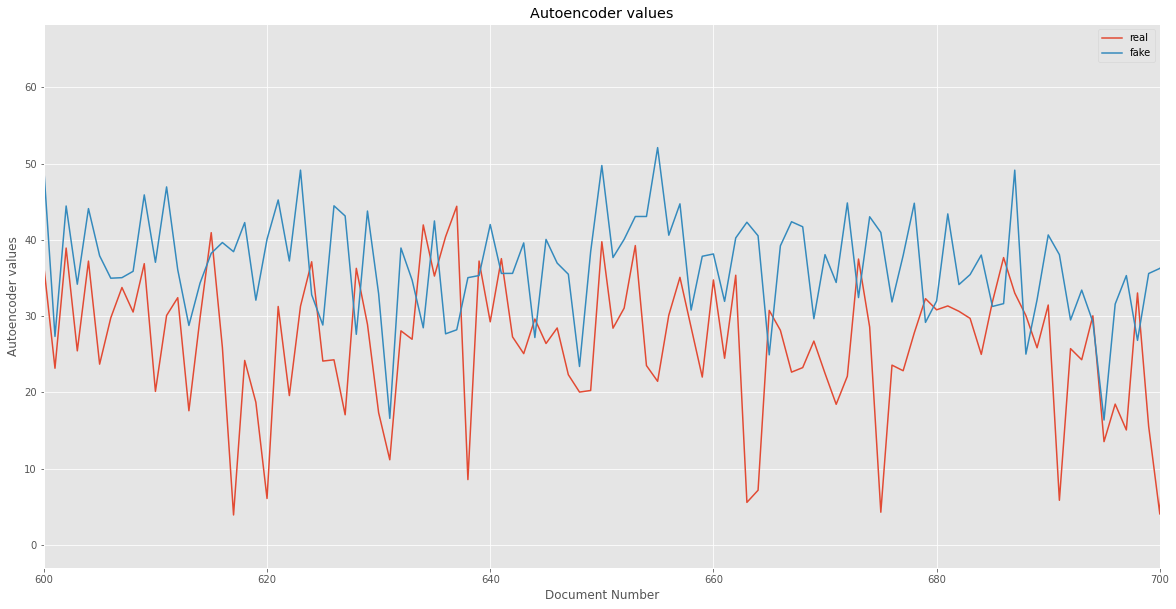

In [71]:
plt.figure(figsize=(20,10))
plt.plot(x_real,df.autoencoder_val, label='real')
plt.plot(x_fake,fake_df.autoencoder_val, label = 'fake')
plt.legend(prop={'size': 10})
plt.xlim(600,700)
plt.title('Autoencoder values')
plt.ylabel('Autoencoder values')
plt.xlabel('Document Number')

In [76]:
from scipy.stats import ttest_ind
ttest_ind(df.autoencoder_val,fake_df.autoencoder_val)

Ttest_indResult(statistic=-21.231623021024, pvalue=1.3900490025376585e-94)

In [87]:
fake_df.value_counts()

1    2031
0     100
Name: label, dtype: int64

In [86]:
fake_df.label.replace(to_replace=-1,value=0,inplace=True)
fake_df.label.value_counts()

1    2031
0    1736
Name: label, dtype: int64

In [90]:
len(fake_df.columns)

10

In [94]:
df.columns

Index(['product', 'link', 'article_content', 'source', 'label', 'tokens',
       'vectors', 'tsne_X', 'tsne_y', 'KMeans_labels', 'autoencoder_val'],
      dtype='object')

In [96]:
combined_df = pd.concat([df.drop('KMeans_labels',axis=1),fake_df])
combined_df

,product,link,article_content,source,label,tokens,vectors,tsne_X,tsne_y,autoencoder_val
0,Vaccine selfies are everywhere. That's actuall...,https://www.cnn.com/2021/03/06/tech/covid-vacc...,As the main caretaker for her immunocompromise...,cnn,0,"[main, caretaker, immunocompromised, mother, s...","[-0.6517257, -0.58543515, 0.5543676, 0.4576794...",22.363464,15.868487,43.017591
1,"Amanda Gorman, inaugural poet, 'tailed' by sec...",https://www.cnn.com/2021/03/06/us/amanda-gorma...,"""A security guard tailed me on my walk home to...",cnn,0,"[security, guard, tailed, walk, home, tonight,...","[-0.54537237, -0.036030173, 0.5389945, 0.30385...",-17.793360,15.806241,33.409280
2,The legendary Iditarod sled dog race is going ...,https://www.cnn.com/2021/03/06/sport/iditarod-...,"The route, usually almost 1,000 miles, has bee...",cnn,0,"[route, usually, almost, miles, modified, avoi...","[-0.095070474, -0.22879435, -0.19022776, 0.364...",1.831776,23.378225,26.763253
3,There's a lot of misinformation around what's ...,https://www.cnn.com/2021/03/06/politics/us-mex...,US Customs and Border Protection has attribute...,cnn,0,"[us, customs, border, protection, attributed, ...","[0.40281138, 0.25570744, 0.2818255, 0.5900684,...",4.375418,12.266811,24.075420
4,A drained swimming pool shows how racism harms...,https://www.cnn.com/2021/03/05/us/heather-mcgh...,The Fairground Park pool in St. Louis was the ...,cnn,0,"[fairground, park, pool, st, louis, largest, p...","[-0.560412, 0.64223176, -0.060790766, 1.203968...",-12.405573,20.319353,26.456397
...,...,...,...,...,...,...,...,...,...,...
3762,Activists paint barriers with names of female ...,https://www.reuters.com/article/us-womens-day-...,MEXICO CITY (Reuters) - The names of women vic...,Reuters,0,"[mexico, city, reuters, names, women, victimiz...","[-1.1972796, -0.03920891, 1.1315296, 0.0023020...",14.529819,-11.177903,23.777348
3763,Ruling RHDP party wins majority in Ivory Coast...,https://www.reuters.com/article/us-ivorycoast-...,DAKAR (Reuters) - Ivory Coast’s ruling party w...,Reuters,0,"[dakar, reuters, ivory, coast, ruling, party, ...","[-0.6283255, -0.46752945, 0.3191623, 0.7113648...",10.475356,-15.216311,29.673014
3764,Dynamite explosions at army base in Equatorial...,https://www.reuters.com/article/us-equatorial-...,MALABO (Reuters) - A series of large explosion...,Reuters,0,"[malabo, reuters, series, large, explosions, m...","[-0.18683566, -0.1433568, 0.9069601, 0.5325149...",15.867410,-13.774384,21.647992
3765,Libyan MPs arrive at Sirte to debate unity gov...,https://www.reuters.com/article/us-libya-secur...,"SIRTE, Libya (Reuters) - Scores of Libyan parl...",Reuters,0,"[sirte, libya, reuters, scores, libyan, parlia...","[-0.22225226, -0.22291505, 0.32047728, 0.49419...",13.321461,-24.788374,11.950028


In [152]:
#4 - label, 9 - autoencoder
def get_autoencoder_score(df,threshold=40):
    predictions = []
    for index, row in df.iterrows():
        label = row[4]
        autoencoder_val = row[9]
        prediction = is_prediction_accurate(label, autoencoder_val, threshold)
        predictions.append(prediction)
    return np.mean(predictions)
    
def is_prediction_accurate(label, autoencoder_val, threshold):
    if label == 0:
        if autoencoder_val < threshold:
            return 1
        else:
            return 0
    elif label == 1:
        if autoencoder_val >= threshold:
            return 1
        else:
            return 0

In [155]:
results = []
thresholds = list(range(101))
for i in range(101):
    result = get_autoencoder_score(combined_df,threshold=i)
    results.append(result)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


Text(0.5, 0, 'Threshold Values')

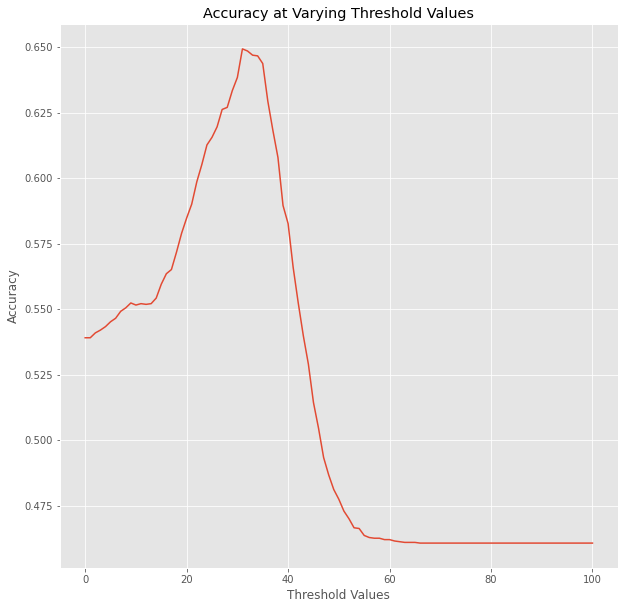

In [158]:
plt.figure(figsize=(10,10))
plt.plot(thresholds,results)
plt.title('Accuracy at Varying Threshold Values')
plt.ylabel('Accuracy')
plt.xlabel('Threshold Values')